In [1]:
import sys
import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from train_bdt import create_hists

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

OUT_DIR = "reports/weekly/2023-09-14"
T2_OUT_DIR = "/storage/af/user/psimmerl/LLP/mdc_analysis"  # os.getcwd()
LOCAL_OUT_DIR = "/home/psimmerl/LLP/mdc_analysis"  # os.getcwd()

DATA_VERSION = "6"
LUMI = 23.02 * 1000

T2_DATA_DIR = "/storage/cms/store/user/christiw/displacedJetMuonAnalyzer/Run3/V1p19"
LOCAL_DATA_DIR = "/home/psimmerl/LLP/mdc_analysis/data/raw"  # os.getcwd() + "/data/raw"
DATA_DIR = "TIER2" if "caltech" in uname()[1] else "LOCAL"

FN_MC = "ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted"
FN_R3 = "DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi"

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
BOT_MARGIN, TOP_MARGIN = 0.025, 0.1
gc = []

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"
    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"
    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #



/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allocator_args.h" [optional] 

Welcome to JupyROOT 6.28/04


In [2]:
N_EVENTS = -1

###

ms_mc = MuonSystemAwkward(FN_MC, name="Signal", nev=N_EVENTS, is_mc=True, lumi=LUMI)

ms_mc.cut = False
ms_mc.match_mc("csc,dt", has_clusters=True)
# ms_mc.cut_hlt()
ms_mc.f(ms_mc["cscMe11Ratio"] + ms_mc["cscMe12Ratio"] == 0, "csc")
ms_mc.f(ms_mc["dtNHitStation1"] == 0, "dt")
ms_mc.cut_l1()
ms_mc.cut_time("csc")
ms_mc.cut_time("dt", invert=False) #! DT TIME CUT
# ms_mc.cut_halo(invert=False) #! HALO CUT
ms_mc.tag(tags="cscdt")
ms_mc.cut = True

###

ms_r3_dtit = MuonSystemAwkward(FN_R3, name="Data DTIT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

ms_r3_dtit.cut = False
# ms_r3_dtit.cut_hlt()
ms_r3_dtit.f(ms_r3_dtit["cscMe11Ratio"] + ms_r3_dtit["cscMe12Ratio"] == 0, "csc")
ms_r3_dtit.f(ms_r3_dtit["dtNHitStation1"] == 0, "dt")
ms_r3_dtit.cut_l1()
ms_r3_dtit.cut_time("csc")
ms_r3_dtit.cut_time("dt", invert=False) #! DT TIME CUT
# ms_r3_dtit.cut_halo(invert=False) #! HALO CUT
ms_r3_dtit.tag(tags="cscdt")
# ms_r3_dtit.f((ms_r3_dtit["dtSize"] < ABCD_DTSIZE) | (ms_r3_dtit["tag_dPhi"] < ABCD_DPHI), "dt")
ms_r3_dtit.cut = True

###

ms_r3_dtoot = MuonSystemAwkward(FN_R3, name="Data DTOOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

ms_r3_dtoot.cut = False
# ms_r3_dtoot.cut_hlt()
ms_r3_dtoot.f(ms_r3_dtoot["cscMe11Ratio"] + ms_r3_dtoot["cscMe12Ratio"] == 0, "csc")
ms_r3_dtoot.f(ms_r3_dtoot["dtNHitStation1"] == 0, "dt")
ms_r3_dtoot.cut_l1()
ms_r3_dtoot.cut_time("csc")
ms_r3_dtoot.cut_time("dt", invert=True) #! DT TIME CUT
# ms_r3_dtoot.cut_halo(invert=False) #! HALO CUT
ms_r3_dtoot.tag(tags="cscdt")
ms_r3_dtoot.cut = True

###

mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]
names = [ms.name for ms in mss]
weights = [ms["weight"] for ms in mss]

print("")
for ims, ms in enumerate(mss):
    print(f"{ms.name:>{max([len(n) for n in names])}} = {ms.count():,.1f} events")
    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]

colors = [ms.colors[0] for ms in mss]


Building MuonSystemAwkward 'Signal' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data DTIT' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi_v6.root'
  Extracted 14,597,375 events
Building MuonSystemAwkward 'Data DTOOT' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi_v6.root'
  Extracted 14,597,375 events

    Signal = 985.3 events
 Data DTIT = 683.0 events
Data DTOOT = 5,985.0 events


In [3]:
bins = [int(np.pi/3*10), 0, np.pi]
values = [ms["dtPhi.abs"] for ms in mss]
canvas, legend, hists = create_hists(
    values, bins, names, ["|#phi_{DT}|", "events"], weights, colors, styles=None, log=None, norm=False
)
canvas.Draw()

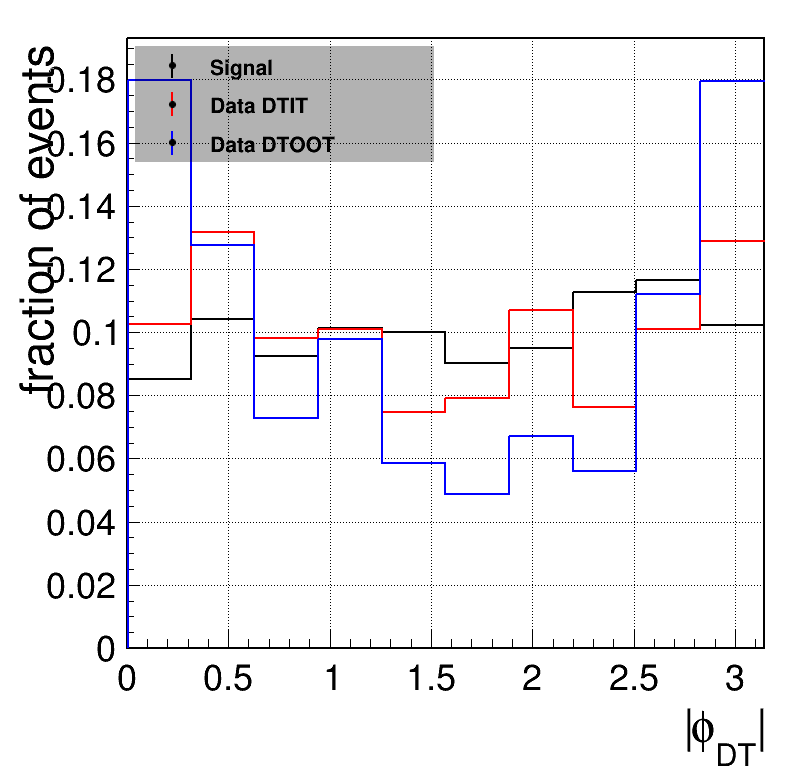

In [ ]:
values = [ms["dtPhi.abs"] for ms in mss]
canvas, legend, hists = create_hists(
    values, bins, names, ["|#phi_{DT}|", "fraction of events"], weights, colors, styles=None, log=None, norm=True
)
canvas.Draw()

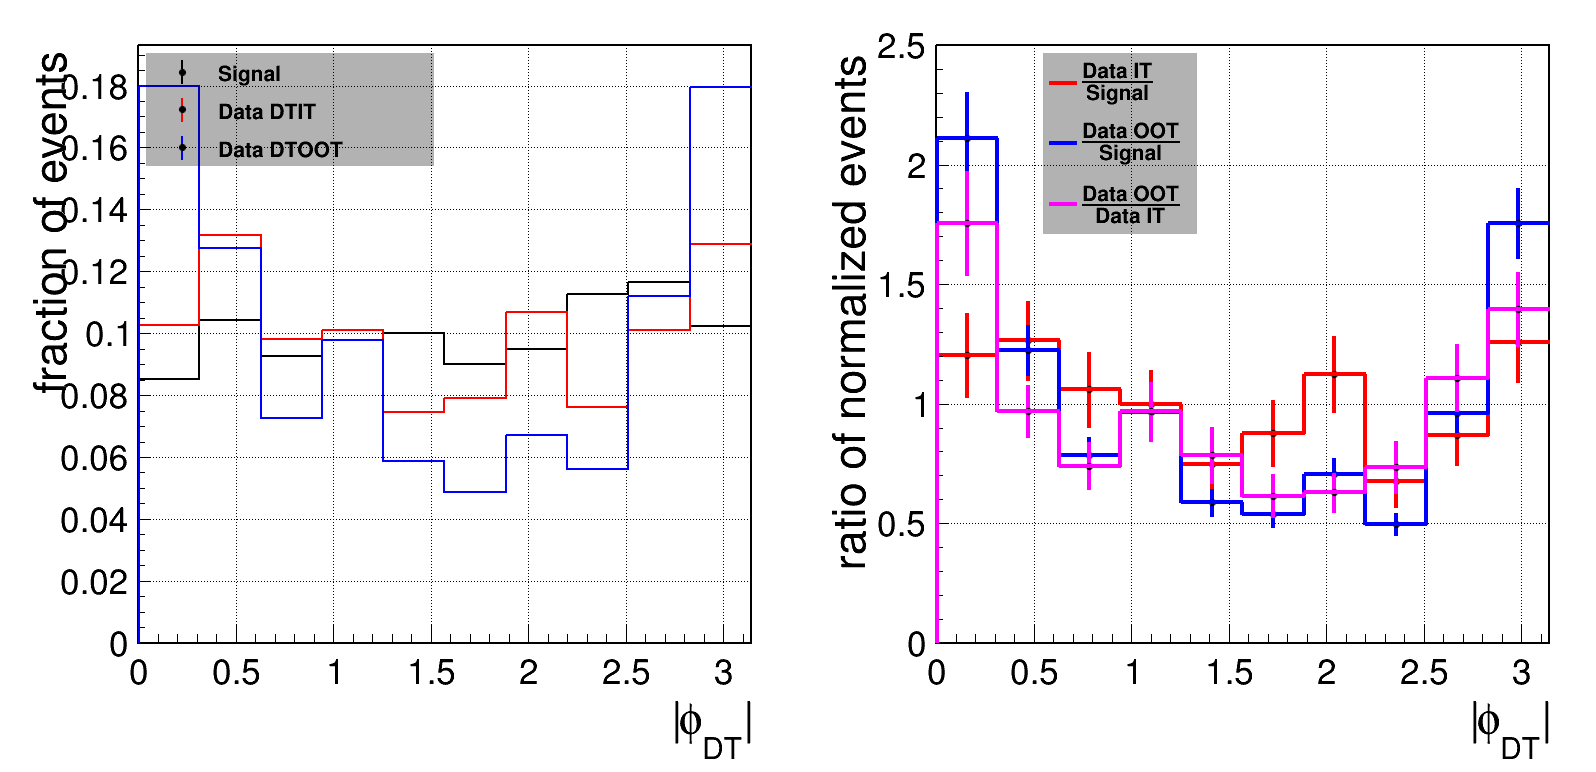

In [ ]:
canvas = rt.TCanvas(f"c{np.random.randint(999999999)}", "c", 2*800, 800)
canvas.Divide(2,1)
###

canvas.cd(1).SetGrid()
canvas.cd(1).SetRightMargin(0.04)

canvas.cd(1)
hists[0].Draw("hist same")
hists[1].Draw("hist same")
hists[2].Draw("hist same")
legend.Draw()

###

canvas.cd(2).SetGrid()
canvas.cd(2).SetRightMargin(0.04)

legend2 = rt.TLegend(0.3, 0.70, 0.5, 0.94)
legend2.SetTextFont(62)
legend2.SetTextSize(0.03)
legend2.SetBorderSize(0)
legend2.SetFillColorAlpha(1, 0.3)
legend2.SetEntrySeparation(0.01)

labels = ["#frac{Data IT}{Signal}", "#frac{Data OOT}{Signal}", "#frac{Data OOT}{Data IT}"]
hnumes = [hists[1], hists[2], hists[2]]
hdenos = [hists[0], hists[0], hists[1]]
for label, hnum, hden in zip(labels, hnumes, hdenos):
    if label != "#frac{Data OOT}{Data IT}":
        continue
    h_ratio = hnum.Clone()
    h_ratio.Divide(hden)

    h_ratio.SetYTitle("ratio of normalized events")
    if "OOT" in label and "IT" in label:
        h_ratio.SetLineColor(rt.kMagenta)
    h_ratio.SetLineWidth(4)
    # h_ratio.SetFillColorAlpha(rt.kRed, 0.3)

    # print(h_ratio.GetMinimum(0))
    # print(h_ratio.GetMaximum())

    h_ratio.SetMinimum(0)#h_dtoot_dtit.GetMinimum(0))
    h_ratio.SetMaximum(2.5)#h_dtoot_dtit.GetMaximum()*(1+TOP_MARGIN))

    h_ratio.Draw("hist E1 same")
    # h_ratio.Draw("hist E1 same")
    legend2.AddEntry(h_ratio, label, "L")
    gc.append(h_ratio)

legend2.Draw()
canvas.Draw()